In [13]:
import os
os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"
from matplotlib import pyplot as plt
import numpy as np
from pprint import pprint
import pandas as pd
import rasterio
from rasterio.windows import Window
import geopandas as gpd

from pystac import (Catalog, CatalogType, Item, Asset, LabelItem, Collection)

In [41]:
# overwriting STAC_IO read method to handle http/s as per https://pystac.readthedocs.io/en/latest/concepts.html#using-stac-io

from urllib.parse import urlparse
import requests
from pystac import STAC_IO

def my_read_method(uri):
    parsed = urlparse(uri)
    if parsed.scheme.startswith('http'):
        return requests.get(uri).text
    else:
        return STAC_IO.default_read_text_method(uri)

STAC_IO.read_text_method = my_read_method

from rasterio.features import rasterize


In [42]:
train1_cat = Catalog.from_file('./train_tier_1/catalog.json')
cols = {cols.id:cols for cols in train1_cat.get_children()}

scene_id = '665946'
col = 'acc'

item = None
for ii in cols[col].get_all_items():
    if str(ii.id )== str(scene_id):
        # print('ok')
        rasterio.open(ii.make_asset_hrefs_absolute().assets['image'].href).meta
        item = ii
    if str(ii.id )== str(scene_id + "-labels"):
        #rasterio.open(ii.make_asset_hrefs_absolute().assets['labels'].href).meta
        gpd.read_file(ii.make_asset_hrefs_absolute().assets['labels'].href)
        item_label = ii
one_item = cols[col].get_item(id=item.id)

rst = rasterio.open(one_item.assets['image'].href)

win_sz = 1024
x = 500
y = 500

window = Window(x, y, win_sz,win_sz) # 1024x1024 window starting at center of raster
win_arr = rst.read(window=window)
win_arr = np.moveaxis(win_arr,0,2)

win_box = box(*rasterio.windows.bounds(window, rst.meta['transform']))
win_box_gdf = gpd.GeoDataFrame(geometry=[win_box], crs=rst.meta['crs'])
#win_box_gdf = win_box_gdf.to_crs({'init':'epsg:4326'}) # ignore FutureWarning for now, updating this arg to crs=4326 creates an error during gpd.sjoin()


# Get labels

one_item_label = cols[col].get_item(id=item_label.id)
one_item_label.to_dict()

scene_labels_gdf = gpd.read_file(one_item_label.assets['labels'].href)

gdf_chip = gpd.sjoin(scene_labels_gdf, win_box_gdf, how='inner', op='intersects')


burn_val = 255
shapes = [(geom, burn_val) for geom in gdf_chip.geometry]

chip_tfm = rasterio.transform.from_bounds(*win_box_gdf.bounds.values[0], win_sz, win_sz)
label_arr = rasterize(shapes, (win_sz, win_sz), transform=chip_tfm, dtype='uint8')

/home/myr/anaconda3/envs/tried/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32630"]])
  "(%s != %s)" % (left_df.crs, right_df.crs)


ValueError: No valid geometry objects found for rasterize

In [45]:
def get_data(catalog_path, seuil = 500*500):
    cat = Catalog.from_file(catalog_path)
    df = {
        "path" : [],
        "pos_x"  : [],
        "pos_y"  : [],
        "col"  : [],
        "id"   : []
    }
    cols = {cols.id:cols for cols in cat.get_children()}
    n = 59000
    j = 0
    kim = 0
    for col in list(cols.keys()):
        for i in list(cols[col].get_all_items()):
            ii = i.id
           
            if "-labels" in str(ii):
                j+=1
                if j%1000 == 0:
                    print(str(j) + '/' + str(n) + "| kept images : "+ str(kim))
                        
                pass
            else:
                print(col)
                print(ii)
                rasterio.open(i.make_asset_hrefs_absolute().assets['image'].href).meta
                one_item = cols[col].get_item(id=ii)
                #print(one_item.to_dict())
                rst = rasterio.open(one_item.assets['image'].href)

                width = rst.meta['width']
                height = rst.meta['height']
                win_sz = 1024
                
                for x in range(width//win_sz):
                    for y in range(height//win_sz):
                        j += 1
                        if j%1000 == 0:
                            print(str(j) + '/' + str(n) + "| kept images : "+ str(kim))
                        
                        window = Window(x*win_sz, y*win_sz,win_sz,win_sz) # 1024x1024 window starting at center of raster
                        win_arr = rst.read(window=window)
                        win_arr = np.moveaxis(win_arr,0,2)
                        
                        if np.sum(win_arr != 0) > seuil:
                            df['col'].append(col)
                            df['id'].append(ii)
                            df['pos_x'].append(x*1024)
                            df['pos_y'].append(y*1024)
                            df['path'].append(catalog_path)
                            kim += 1
    return pd.DataFrame(df)
                             
            
    

In [46]:
df = get_data('./train_tier_1/catalog.json')

acc
665946
1000/59000| kept images : 63
2000/59000| kept images : 234
3000/59000| kept images : 514
4000/59000| kept images : 895
5000/59000| kept images : 1464
6000/59000| kept images : 2139
7000/59000| kept images : 2842
8000/59000| kept images : 3535
9000/59000| kept images : 4153
10000/59000| kept images : 4747
11000/59000| kept images : 5288
acc
a42435
12000/59000| kept images : 5548
13000/59000| kept images : 6122
14000/59000| kept images : 6887
acc
ca041a
15000/59000| kept images : 7186
16000/59000| kept images : 7587
17000/59000| kept images : 8150
18000/59000| kept images : 8473
acc
d41d81
19000/59000| kept images : 8621
20000/59000| kept images : 9261
mon
401175
mon
493701
21000/59000| kept images : 9749
mon
207cc7
mon
f15272
ptn
abe1a3
ptn
f49f31
kam
4e7c7f
22000/59000| kept images : 10354
23000/59000| kept images : 10974
dar
a017f9
24000/59000| kept images : 11561
25000/59000| kept images : 12148
dar
b15fce
26000/59000| kept images : 12999
27000/59000| kept images : 13848
d

In [48]:
df.to_csv("data.csv")

In [11]:
*[1,2,3]

SyntaxError: can't use starred expression here (<ipython-input-11-63179bdb9a80>, line 4)

In [15]:
# load our training and test catalogs

train1_cat = Catalog.from_file('./train_tier_1/catalog.json')
train2_cat = Catalog.from_file('./train_tier_2/catalog.json')
test_cat = Catalog.from_file('./test/catalog.json')

In [16]:
# make a dict of all collections witinin train1 catalog

cols = {cols.id:cols for cols in train1_cat.get_children()}
cols

{'acc': <Collection id=acc>,
 'mon': <Collection id=mon>,
 'ptn': <Collection id=ptn>,
 'kam': <Collection id=kam>,
 'dar': <Collection id=dar>,
 'znz': <Collection id=znz>,
 'nia': <Collection id=nia>}

In [17]:
# look at the acc collection, as a dict
cols['acc'].to_dict()

{'id': 'acc',
 'stac_version': '0.8.1',
 'description': 'Tier 1 training data from acc',
 'links': [{'rel': 'item',
   'href': './665946/665946.json',
   'type': 'application/json'},
  {'rel': 'item',
   'href': './665946-labels/665946-labels.json',
   'type': 'application/json'},
  {'rel': 'item', 'href': './a42435/a42435.json', 'type': 'application/json'},
  {'rel': 'item',
   'href': './a42435-labels/a42435-labels.json',
   'type': 'application/json'},
  {'rel': 'item', 'href': './ca041a/ca041a.json', 'type': 'application/json'},
  {'rel': 'item',
   'href': './ca041a-labels/ca041a-labels.json',
   'type': 'application/json'},
  {'rel': 'item', 'href': './d41d81/d41d81.json', 'type': 'application/json'},
  {'rel': 'item',
   'href': './d41d81-labels/d41d81-labels.json',
   'type': 'application/json'},
  {'rel': 'self',
   'href': '/home/myr/project/houses/train_tier_1/acc/collection.json',
   'type': 'application/json'},
  {'rel': 'root', 'href': '../catalog.json', 'type': 'applicat

In [18]:

# iterate through all the items within acc collection and print their ids
for i in cols['acc'].get_all_items():
    print(i.id)

665946
665946-labels
a42435
a42435-labels
ca041a
ca041a-labels
d41d81
d41d81-labels


In [19]:
list(cols['acc'].get_all_items())

[<Item id=665946>,
 <LabelItem id=665946-labels>,
 <Item id=a42435>,
 <LabelItem id=a42435-labels>,
 <Item id=ca041a>,
 <LabelItem id=ca041a-labels>,
 <Item id=d41d81>,
 <LabelItem id=d41d81-labels>]

In [21]:
np.array(list(cols['acc'].get_all_items()))

array([<Item id=665946>, <LabelItem id=665946-labels>, <Item id=a42435>,
       <LabelItem id=a42435-labels>, <Item id=ca041a>,
       <LabelItem id=ca041a-labels>, <Item id=d41d81>,
       <LabelItem id=d41d81-labels>], dtype=object)

In [22]:
a = cols['acc'].get_all_items()

665946 
----------------------------
{'area': 'acc', 'datetime': '2018-08-05T00:00:00Z', 'license': 'CC BY 4.0'}
raster metadata:
{'count': 4,
 'crs': CRS.from_epsg(32630),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 150147,
 'nodata': None,
 'transform': Affine(0.02001518707102818, 0.0, 805429.9166958937,
       0.0, -0.02001518707102818, 624939.1898949385),
 'width': 84466}

----------------------------
665946-labels 
----------------------------
{'area': 'acc',
 'datetime': '2018-08-05 00:00:00Z',
 'label:description': 'Geojson building labels for scene 665946',
 'label:overviews': [{'counts': [{'count': 7308, 'name': 'yes'}],
                      'property_key': ['building']}],
 'label:properties': ['building'],
 'label:type': 'vector',
 'license': 'ODbL-1.0'}


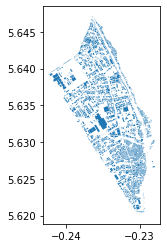


----------------------------
a42435 
----------------------------
{'area': 'acc', 'datetime': '2018-10-06 00:00:00Z', 'license': 'CC BY 4.0'}
raster metadata:
{'count': 4,
 'crs': CRS.from_epsg(32630),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 39162,
 'nodata': None,
 'transform': Affine(0.032029411960186015, 0.0, 804676.2688712641,
       0.0, -0.03202926727370731, 621829.9693785439),
 'width': 57540}

----------------------------
a42435-labels 
----------------------------
{'area': 'acc',
 'datetime': '2018-10-06 00:00:00Z',
 'label:description': 'Geojson building labels for scene a42435',
 'label:overviews': [{'counts': [{'count': 6647, 'name': 'yes'}],
                      'property_key': ['building']}],
 'label:properties': ['building'],
 'label:type': 'vector',
 'license': 'ODbL-1.0'}


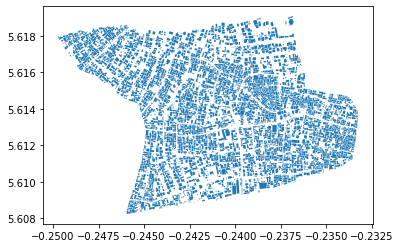


----------------------------
ca041a 
----------------------------
{'area': 'acc', 'datetime': '2018-11-12 00:00:00Z', 'license': 'CC BY 4.0'}
raster metadata:
{'count': 4,
 'crs': CRS.from_epsg(32630),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 77778,
 'nodata': None,
 'transform': Affine(0.035820209694930036, 0.0, 807207.717115721,
       0.0, -0.035820613560994544, 620903.4357975163),
 'width': 65882}

----------------------------
ca041a-labels 
----------------------------
{'area': 'acc',
 'datetime': '2018-11-12 00:00:00Z',
 'label:description': 'Geojson building labels for scene ca041a',
 'label:overviews': [{'counts': [{'count': 10194, 'name': 'yes'}],
                      'property_key': ['building']}],
 'label:properties': ['building'],
 'label:type': 'vector',
 'license': 'ODbL-1.0'}


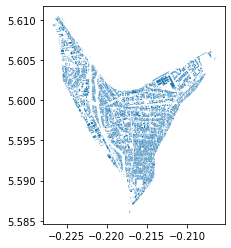


----------------------------
d41d81 
----------------------------
{'area': 'acc', 'datetime': '2019-07-07 00:00:00Z', 'license': 'CC BY 4.0'}
raster metadata:
{'count': 4,
 'crs': CRS.from_epsg(32630),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 42719,
 'nodata': None,
 'transform': Affine(0.05179965064903244, 0.0, 809267.1099320438,
       0.0, -0.05180039261972288, 618981.5459276063),
 'width': 40868}

----------------------------
d41d81-labels 
----------------------------
{'area': 'acc',
 'datetime': '2019-07-07 00:00:00Z',
 'label:description': 'Geojson building labels for scene d41d81',
 'label:overviews': [{'counts': [{'count': 9436, 'name': 'yes'}],
                      'property_key': ['building']}],
 'label:properties': ['building'],
 'label:type': 'vector',
 'license': 'ODbL-1.0'}


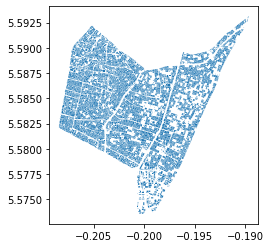


----------------------------


In [25]:
# for all items within acc col, either load and display label geojson with geopandas or raster metadata with rasterio

for i in cols['acc'].get_all_items():
    print(i.id,'\n----------------------------')
    pprint(i.properties)
    if 'label' in i.id:

        gdf = gpd.read_file(i.make_asset_hrefs_absolute().assets['labels'].href)
        gdf.plot()
        plt.show()
    else: 
        print('raster metadata:')
        pprint(rasterio.open(i.make_asset_hrefs_absolute().assets['image'].href).meta)
    print('\n----------------------------')

### Load one image scene and create one training chip (pair of image and label) with windowed reads


In [26]:
# open one image item
SCENE_ID = '665946'

one_item = cols['acc'].get_item(id=SCENE_ID)
one_item.to_dict()

{'type': 'Feature',
 'stac_version': '0.8.1',
 'id': '665946',
 'properties': {'area': 'acc',
  'license': 'CC BY 4.0',
  'datetime': '2018-08-05T00:00:00Z'},
 'geometry': {'coordinates': [[[-0.24297113100354567, 5.639021431491198],
    [-0.23897453489157597, 5.641691785417461],
    [-0.23850428635941076, 5.642250323405412],
    [-0.2366780918775795, 5.646581694873462],
    [-0.2365678982420534, 5.647261088925513],
    [-0.23628962908589524, 5.6470592605205],
    [-0.23574709855965523, 5.646250384519349],
    [-0.23549999005573774, 5.646062606522559],
    [-0.2352479883141164, 5.645837517588297],
    [-0.2351489002506633, 5.645826507803469],
    [-0.23489078196191707, 5.645643011389668],
    [-0.23501342114346913, 5.645366016963376],
    [-0.23498470193337662, 5.645184128632788],
    [-0.23469272329743152, 5.644748553946379],
    [-0.23452040803687635, 5.644241181234739],
    [-0.23438159852142515, 5.644073652509197],
    [-0.23389815848486362, 5.643677566736666],
    [-0.2336588317340

In [27]:
# load raster for this item
rst = rasterio.open(one_item.assets['image'].href)
rst.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 84466,
 'height': 150147,
 'count': 4,
 'crs': CRS.from_epsg(32630),
 'transform': Affine(0.02001518707102818, 0.0, 805429.9166958937,
        0.0, -0.02001518707102818, 624939.1898949385)}

In [28]:

# check raster resolution
rst.res

(0.02001518707102818, 0.02001518707102818)

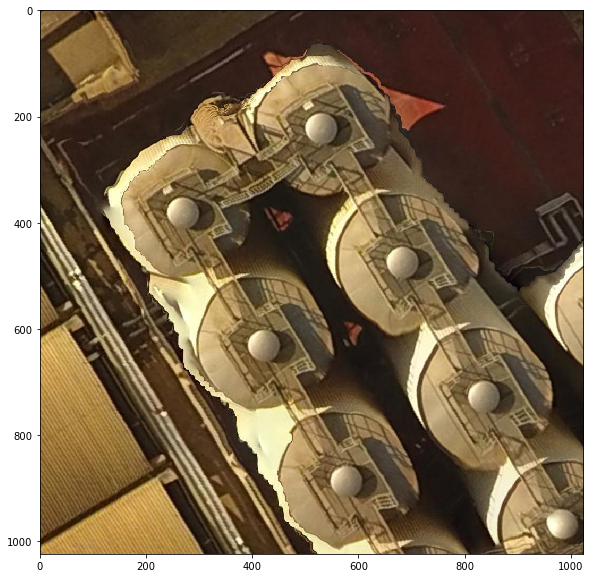

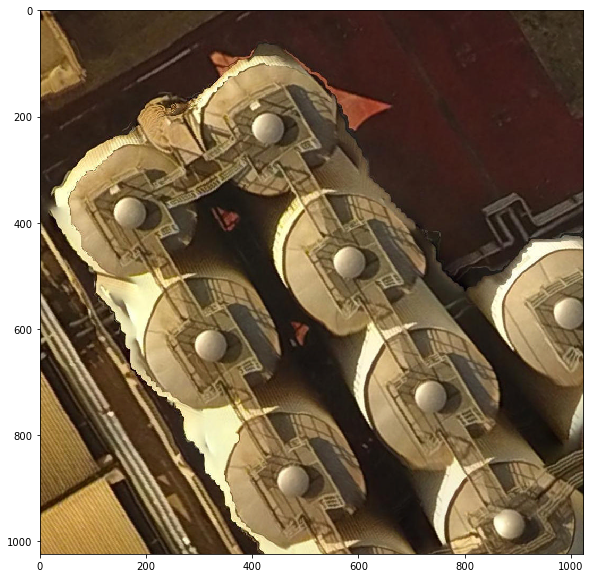

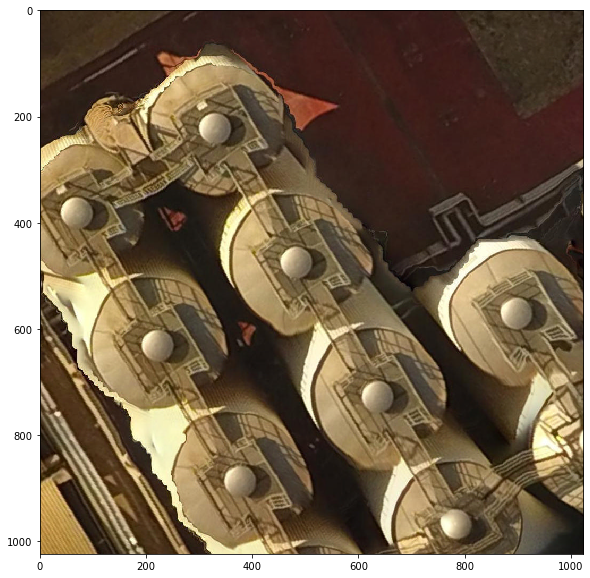

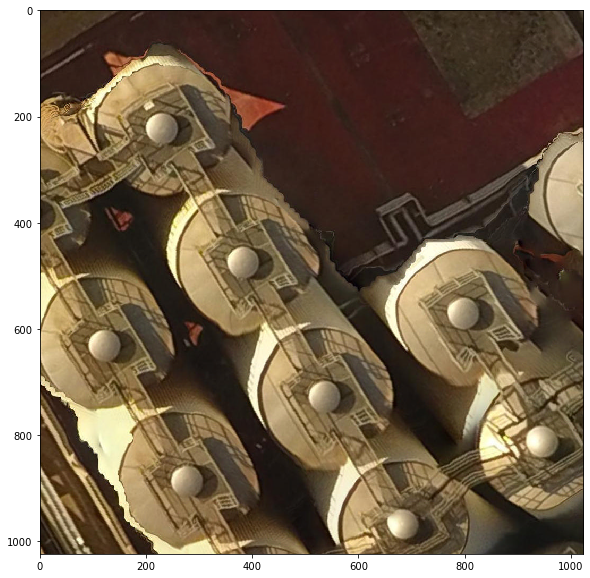

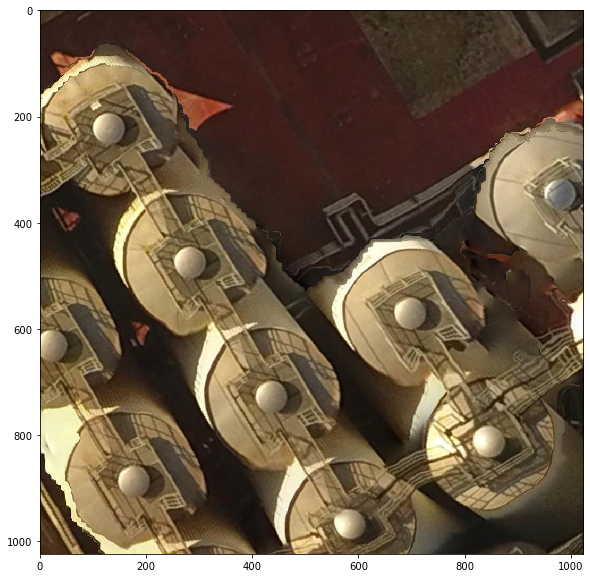

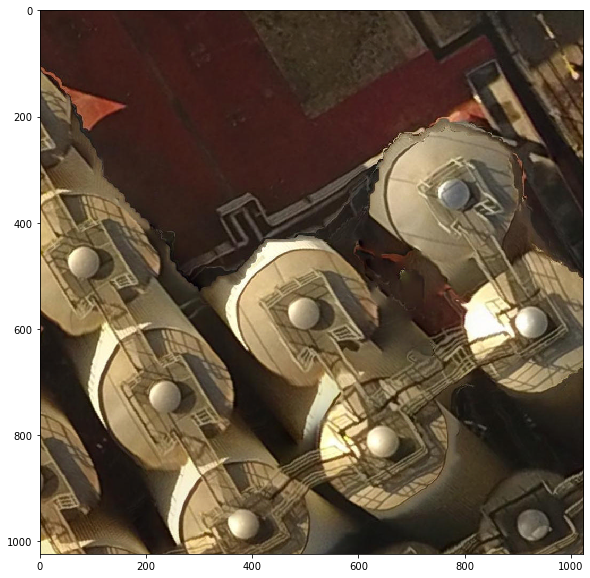

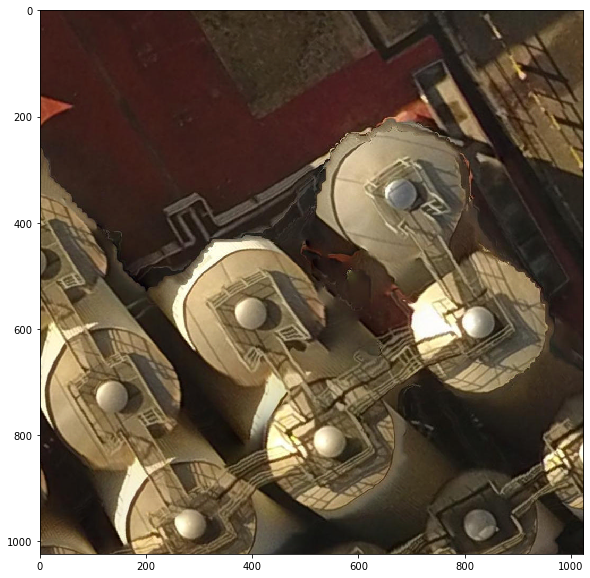

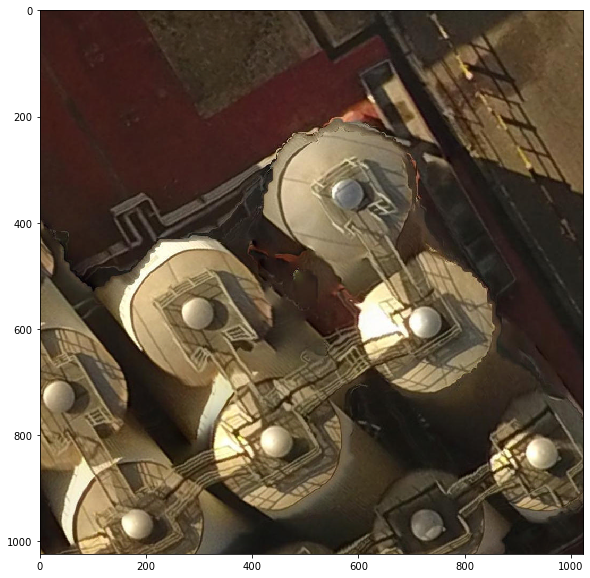

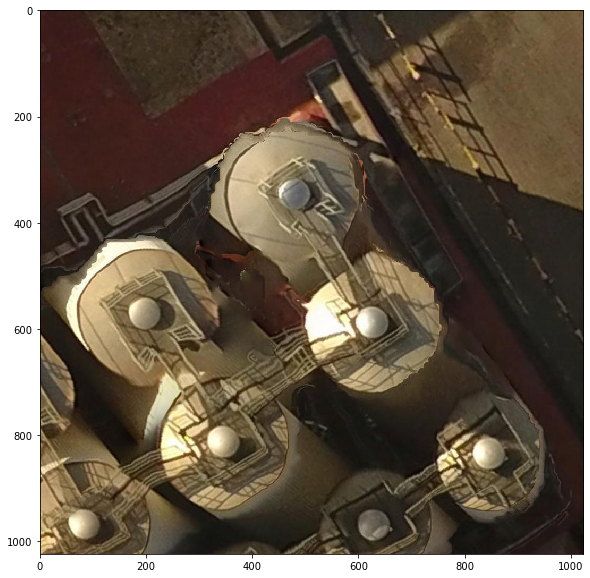

In [29]:
# make a windowed read of this raster and reshape into a displayable 4-d array (RGB+alpha channel)
# more on windowed reads with rasterio: https://rasterio.readthedocs.io/en/stable/topics/windowed-rw.html#windows
for i in range(10):
    win_sz = 1024

    window = Window(rst.meta['width']//2 + i*100,rst.meta['height']//2,win_sz,win_sz) # 1024x1024 window starting at center of raster
    win_arr = rst.read(window=window)
    win_arr = np.moveaxis(win_arr,0,2)
    plt.figure(figsize=(10,10))
    plt.imshow(win_arr)

In [30]:
np.max(win_arr)

255

In [31]:

# create a Polygon box to chip into training image and label 
from shapely.geometry import box
win_box = box(*rasterio.windows.bounds(window, rst.meta['transform']))

+init=epsg:4326 +type=crs


/home/myr/anaconda3/envs/tried/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


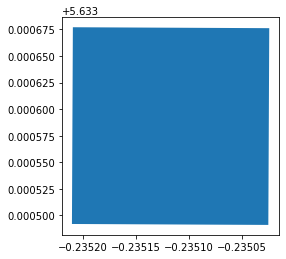

In [32]:
# make box into geodataframe for reprojection and later intersect operation
win_box_gdf = gpd.GeoDataFrame(geometry=[win_box], crs=rst.meta['crs'])
win_box_gdf = win_box_gdf.to_crs({'init':'epsg:4326'}) # ignore FutureWarning for now, updating this arg to crs=4326 creates an error during gpd.sjoin()
print(win_box_gdf.crs)
win_box_gdf.plot()

In [33]:
one_item_label = cols['acc'].get_item(id=SCENE_ID+'-labels')
one_item_label.to_dict()

{'type': 'Feature',
 'stac_version': '0.8.1',
 'id': '665946-labels',
 'properties': {'label:description': 'Geojson building labels for scene 665946',
  'area': 'acc',
  'label:type': 'vector',
  'label:properties': ['building'],
  'label:overviews': [{'property_key': ['building'],
    'counts': [{'name': 'yes', 'count': 7308}]}],
  'license': 'ODbL-1.0',
  'datetime': '2018-08-05T00:00:00Z'},
 'geometry': {'coordinates': [[[-0.24297113100354567, 5.639021431491198],
    [-0.23897453489157597, 5.641691785417461],
    [-0.23850428635941076, 5.642250323405412],
    [-0.2366780918775795, 5.646581694873462],
    [-0.2365678982420534, 5.647261088925513],
    [-0.23628962908589524, 5.6470592605205],
    [-0.23574709855965523, 5.646250384519349],
    [-0.23549999005573774, 5.646062606522559],
    [-0.2352479883141164, 5.645837517588297],
    [-0.2351489002506633, 5.645826507803469],
    [-0.23489078196191707, 5.645643011389668],
    [-0.23501342114346913, 5.645366016963376],
    [-0.2349847019

In [34]:
scene_labels_gdf = gpd.read_file(one_item_label.assets['labels'].href)


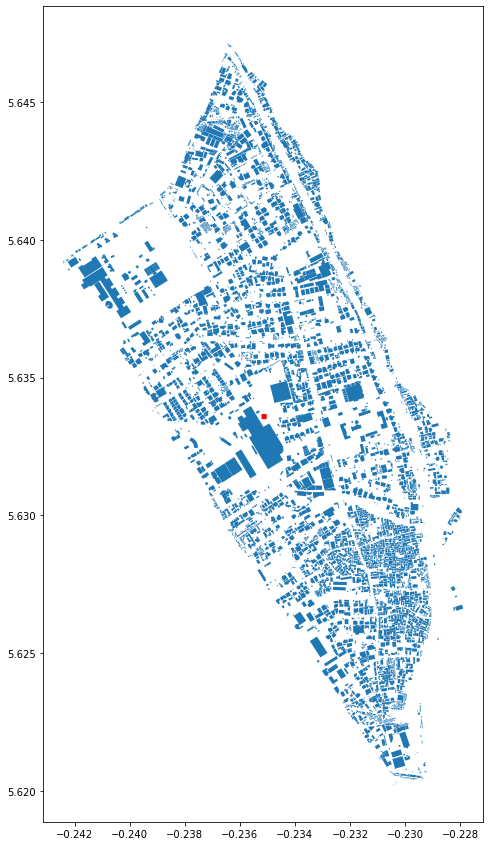

In [35]:

# plot both gdf to visualize where win_box is within the whole image scene
fig, ax = plt.subplots(1,1,figsize=(15,15))
win_box_gdf.plot(ax=ax, color='red')
scene_labels_gdf.plot(ax=ax)

/home/myr/anaconda3/envs/tried/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != +init=epsg:4326 +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)
/home/myr/anaconda3/envs/tried/lib/python3.7/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


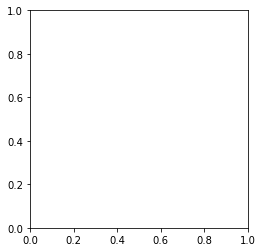

In [36]:

# get the label geoms that intersect with our win_box
gdf_chip = gpd.sjoin(scene_labels_gdf, win_box_gdf, how='inner', op='intersects')
gdf_chip.plot()

In [37]:
# create a list of (geom, burn_val) to pass into rasterio's rasterize function, see: https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.rasterize
burn_val = 255
shapes = [(geom, burn_val) for geom in gdf_chip.geometry]
shapes[0][0]

IndexError: list index out of range

In [64]:

# get the affine transform object for our win_box to pass into rasterize()
print(win_box_gdf.bounds.values[0])
chip_tfm = rasterio.transform.from_bounds(*win_box_gdf.bounds.values[0], win_sz, win_sz)
print(chip_tfm)

[-0.24131881  5.6132236  -0.2410216   5.61352136]
| 0.00, 0.00,-0.24|
| 0.00,-0.00, 5.61|
| 0.00, 0.00, 1.00|


In [65]:
from rasterio.features import rasterize

label_arr = rasterize(shapes, (win_sz, win_sz), transform=chip_tfm, dtype='uint8')

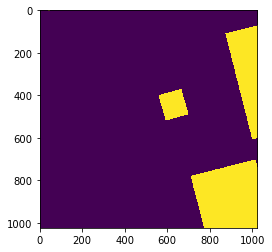

In [66]:
plt.imshow(label_arr)


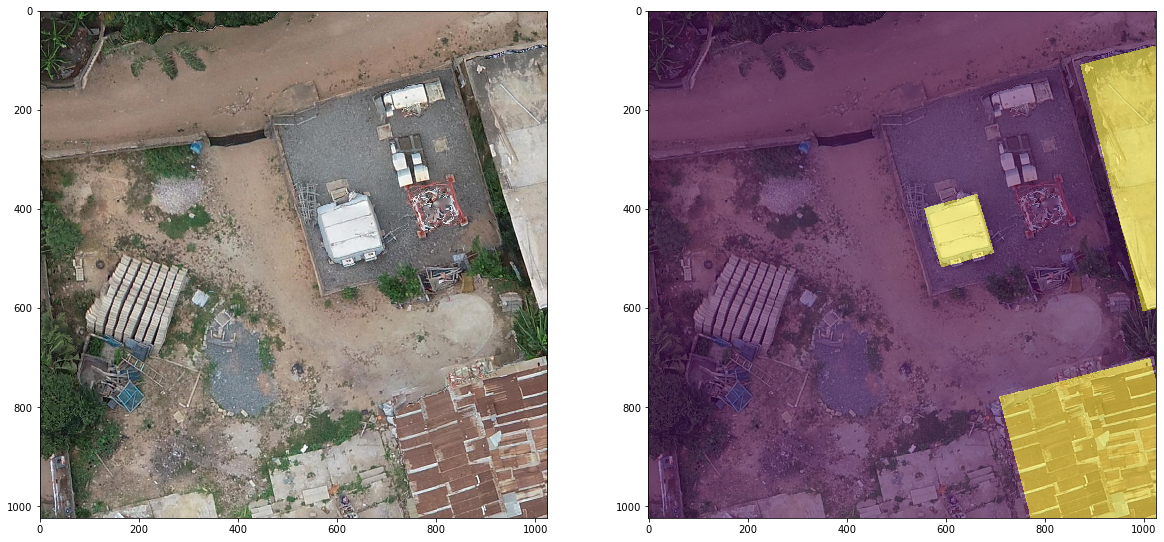

In [67]:

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(win_arr)
ax2.imshow(win_arr)
ax2.imshow(label_arr, alpha=0.5)

### Bonus material on saving chipped images and labels as geotiffs


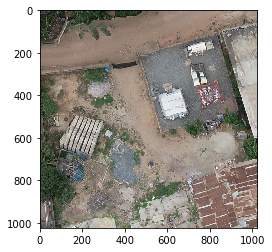

In [68]:

plt.imshow(win_arr)

In [69]:
chip_tfm


Affine(2.902421664139688e-07, 0.0, -0.24131881273942365,
       0.0, -2.90777117436386e-07, 5.613521356536048)

In [70]:
def save_geochip(arr, chip_tfm, save_fn='test', crs='epsg:4326', dtype='uint8'):
    im = (arr).astype(dtype)

    # check im shape, number of channels and expand into (H,W,C) if needed
    if len(im.shape) == 3: num_ch = im.shape[-1]
    else: 
        num_ch = 1
        im = np.expand_dims(im, -1)

    with rasterio.open(save_fn+'.tif', 'w', driver='GTiff', 
                            height=im.shape[0], width=im.shape[1],
                            count=num_ch, dtype=im.dtype, transform=chip_tfm, compress='LZW') as dst:
        
        for ch in range(num_ch):
            dst.write(im[:,:,ch], indexes=ch+1) #indexes start at 1

In [71]:
save_geochip(win_arr, chip_tfm)
save_geochip(label_arr, chip_tfm, 'label')